In [296]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import random
import matplotlib.pyplot as plt

In [297]:
NUMBER_OF_PLAYERS = 2
ROWS = 10                        
COLS = 20    

MAP_NAME = "GeneticBestMap"

POPULATION_SIZE = 10            
MUTATION_RATE = 0.5           
SCORE_TO_ACHIEVE = 100           
FITNESS_THRESHOLD = 25        
ELITE_COUNT = 2                 

HEX_RADIUS = 1                 

In [298]:

tundra_colours = {
    "Mountain": "#9AA9A0",
    "Hill": "#B0B9B4",
    "Flat": "#D9E3E2"
}

grassland_colours = {
    "Mountain": "#6E9E3E",
    "Hill":     "#8FBF4A",
    "Flat":     "#A3D14A"
}

tropical_colours = {
    "Mountain": "#6E9E8F",
    "Hill":     "#8FBF9E",
    "Flat":     "#A3D1B7"
}

desert_colours = {
    "Mountain": "#C4B37F",
    "Hill":     "#D1C48A",
    "Flat":     "#E0D1A3"
}

marine_colours = {
    "Coast": "#4A8FBF",
    "Ocean": "#3E6E9E"
}


biome_colours = {
    "Tundra": tundra_colours,
    "Grassland": grassland_colours,
    "Tropical": tropical_colours,
    "Desert": desert_colours,
    "Marine": marine_colours
}


In [299]:

def generate_hex_grid(rows, cols, biomes, num_players):
    
    # Generate all tiles (row, col)
    all_positions = [(r, c) for r in range(rows) for c in range(cols)]
    
    # Randomly place tiles for players
    start_positions = random.sample(all_positions, num_players)

    # Tile data dictionary to store color, biome, terrain
    tile_data = {}

    # For every tile, give set a property
    for row in range(rows):
        for col in range(cols):

            # If the position coordinates are a start position, make it black
            if (row, col) in start_positions:
                hex_color = 'black'
                biome = 'Spawn'
                terrain_type = 'Spawn'
            else:
                # Pick a random biome and terrain
                biome = random.choice(list(biomes.keys()))
                terrain_type = random.choice(list(biomes[biome].keys()))
                hex_color = biomes[biome][terrain_type]  # Get color

            # Store the tile data (row, col)
            tile_data[(row, col)] = {
                'color': hex_color,
                'biome': biome,
                'terrain': terrain_type
            }

    return start_positions, tile_data


In [300]:

def plot_map(ax, tile_map, spawns):
    hex_height = math.sqrt(3) * HEX_RADIUS

    for (row, col), tile_info in tile_map.items():
        x_offset = col * 1.5 * HEX_RADIUS
        y_offset = row * hex_height + (hex_height / 2 if col % 2 == 1 else 0)
        hex_color = tile_info['color']

        # Spawn positions are black
        if (row, col) in spawns:
            hex_color = 'black'

        hex_tile = patches.RegularPolygon(
            (x_offset, y_offset),
            numVertices=6,
            radius=HEX_RADIUS,
            orientation=math.radians(30),
            facecolor=hex_color,
            edgecolor='black'
        )
        ax.add_patch(hex_tile)

    ax.set_aspect('equal')
    ax.autoscale_view()
    ax.axis('off')


def plot_top_maps(top_maps):

    # Sort maps in descending order
    top_maps = sorted(top_maps, key=lambda x: x['score'], reverse=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(ROWS, COLS))

    # Plot top 2 maps
    spawns1, tile_map1 = top_maps[0]['spawns'], top_maps[0]['map']
    ax1.set_title(f"Map 1: Score {top_maps[0]['score']}")
    plot_map(ax1, tile_map1, spawns1)

    spawns2, tile_map2 = top_maps[1]['spawns'], top_maps[1]['map']
    ax2.set_title(f"Map 2: Score {top_maps[1]['score']}")
    plot_map(ax2, tile_map2, spawns2)

    plt.show()


def display_best_map(tile_map, spawns, score=None):
    fig, ax = plt.subplots(figsize=(ROWS, COLS))
    title = f"Best Map"
    if score:
        title += f" - Score {score}"
    ax.set_title(title)
    plot_map(ax, tile_map, spawns)
    plt.show()


In [301]:
def rate_map(tile_data, start_positions, rows, cols):
    import math
    import numpy as np

    def neighbors(pos):
        row, col = pos
        even_col = col % 2 == 0
        directions = [(-1, 0), (-1, +1), (0, -1), (0, +1), (+1, 0), (+1, +1)] if even_col else \
                     [(-1, -1), (-1, 0), (0, -1), (0, +1), (+1, -1), (+1, 0)]
        return [(row + dr, col + dc) for dr, dc in directions if 0 <= row + dr < rows and 0 <= col + dc < cols]

    biome_score = 0
    terrain_score = 0
    spawn_score = 0
    tundra_proximity_score = 0
    spread_score = 0 

    for (row, col), tile in tile_data.items():
        if tile['biome'] == "Spawn":
            continue

        neighbors_list = [
            n for n in (tile_data.get(pos) for pos in neighbors((row, col))) if n
        ]

        biome_score += sum(n['biome'] == tile['biome'] for n in neighbors_list)

        if tile['biome'] != 'Marine':
            if tile['biome'] == 'Tundra':
                dist_top = row
                dist_bottom = rows - 1 - row
                if dist_top == 0 or dist_bottom == 0:
                    tundra_proximity_score += 5
                elif dist_top == 1 or dist_bottom == 1:
                    tundra_proximity_score += 3
                else:
                    tundra_proximity_score -= 5
            continue

        terrain = tile['terrain']
        water_neighbors = [n for n in neighbors_list if n['terrain'] in ['Ocean', 'Coast']]
        land_adjacent = any(n['biome'] != 'Marine' for n in neighbors_list)

        if terrain == 'Ocean':
            if land_adjacent:
                terrain_score -= 5
            terrain_score += len(water_neighbors)

        elif terrain == 'Coast':
            water_adjacent = any(n['terrain'] in ['Ocean', 'Coast'] for n in neighbors_list)
            if water_adjacent and land_adjacent:
                terrain_score += 3
            else:
                terrain_score -= 2

    for pos in start_positions:
        tile = tile_data.get(pos)

        if tile:
            if tile['biome'] == 'Marine':
                spawn_score -= 100

            land_neighbors = sum(
                1 for n_pos in neighbors(pos)
                if tile_data.get(n_pos) and tile_data[n_pos]['biome'] != 'Marine'
            )

            if land_neighbors == 0:
                spawn_score -= 50
            else:
                spawn_score += land_neighbors * 5

    # === Spread Score reward distance between spawn positions ===
    if len(start_positions) > 1:
        # Create a list to store distances between all spawn points
        distances = []

        # Loop through each pair of spawn positions
        for i in range(len(start_positions)):
            r1, c1 = start_positions[i]
            for j in range(i + 1, len(start_positions)):
                r2, c2 = start_positions[j]
                distance = math.dist((r1, c1), (r2, c2))
                distances.append(distance)

        # Calculate the average distance between spawn points
        if distances:
            average_distance = sum(distances) / len(distances)

            # Reward higher average distance to encourage more spread-out spawns
            spread_score += average_distance * 4

    total_raw_score = biome_score + terrain_score + spawn_score + tundra_proximity_score + spread_score

    max_possible = rows * cols * 6
    rating = int(np.clip((total_raw_score / max_possible) * 100, 0, 100))

    return rating


In [302]:

# Initial population
def generate_initial_population(min_valid_maps=2, fitness_threshold=FITNESS_THRESHOLD, score_to_achieve=SCORE_TO_ACHIEVE):
    best_maps = []
    scores = []
    attempts = []

    attempt = 1
    while len(best_maps) < min_valid_maps:
        # Generate a new map and rate it
        spawns, tile_map = generate_hex_grid(rows=ROWS, cols=COLS, biomes=biome_colours, num_players=NUMBER_OF_PLAYERS)
        score = rate_map(tile_map, spawns, ROWS, COLS)

        scores.append(score)
        attempts.append(attempt)

        # Save maps that are good
        if score >= fitness_threshold:
            best_maps.append({
                'score': score,
                'spawns': spawns,
                'map': tile_map
            })
            print(f"🟢 Saved map {len(best_maps)} with score {score}")
        else:
            print(f"🔴 Discarded map with score {score}")

        # If score exceeds the goal, stop searching
        if score >= score_to_achieve:
            print(f"\n🟢 Found map with score {score}/100 on attempt {attempt}")
            print("Player start positions:", spawns)
            break

        attempt += 1

    print(f"\nDone : {len(best_maps)} maps above {fitness_threshold} fitness")

    # === Plotting the scores over attempts ===
    plt.figure(figsize=(10, 6))
    plt.plot(attempts, scores, marker='o', linestyle='-', color='blue')
    plt.axhline(y=fitness_threshold, color='orange', linestyle='--', label=f'Fitness Threshold ({fitness_threshold})')
    plt.axhline(y=score_to_achieve, color='green', linestyle='--', label=f'Target Score ({score_to_achieve})')
    plt.title('Score per Attempt')
    plt.xlabel('Attempt')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_maps


In [ ]:

# === Elitism Selection ===
def elitism_selection(population, elite_count=ELITE_COUNT):

    # Sort the population in descending order based on the 'score' of each individual
    sorted_population = sorted(
        population,
        key=lambda individual: individual['score'],
        reverse=True
    )
    
    # Select the top 'elite_count' individuals
    elites = []

    # Iterate through the sorted population and add the top 'elite_count' individuals to the elites list
    for i in range(elite_count):
        if i < len(sorted_population):
            elites.append(sorted_population[i])

    return elites

# === Mutation ===
def mutate_map(individual, mutation_rate=MUTATION_RATE):
    tile_map = individual['map']
    if random.random() < mutation_rate:
        target_tile = random.choice(list(tile_map.keys()))
        biome = random.choice(list(biome_colours.keys()))
        terrain = random.choice(list(biome_colours[biome].keys()))
        tile_map[target_tile]['biome'] = biome
        tile_map[target_tile]['terrain'] = terrain
        tile_map[target_tile]['color'] = biome_colours[biome][terrain]
    return individual

# === Reproduce ===
def reproduce_population(parents, total_size=POPULATION_SIZE):
    children = []

    while len(children) < total_size:

        # Select a random parent and make a copy
        clone = random.choice(parents).copy()

        copied_map = {}

        # Iterate through each key-value pair in the original map
        for key, value in clone['map'].items():
            copied_value = value.copy()
            copied_map[key] = copied_value

        clone['map'] = copied_map

        children.append(clone)

    return children

# === Plotting Function ===
def plot_fitness_over_time(generations, scores, score_to_achieve=SCORE_TO_ACHIEVE):
    plt.plot(generations, scores, color='blue')
    plt.axhline(y=score_to_achieve, color='red', linestyle='--', label='Target Score')
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Fitness Over Generations")
    plt.legend()
    plt.show()


In [304]:
def run_genetic_ai_until_goal(population_size=POPULATION_SIZE,fitness_threshold=FITNESS_THRESHOLD,mutation_rate=MUTATION_RATE,score_to_achieve=SCORE_TO_ACHIEVE):
    # Generate the initial population with the given size and fitness threshold
    population = generate_initial_population(population_size, fitness_threshold)

    # Plot the best 2 random maps
    if len(population) >= 2:
        plot_top_maps(population)
        
    # This list will keep track of the best score of each generation
    history = []

    # Generation counter starts at zero
    generation = 0

    # Run the genetic algorithm until we reach the target score
    while True:
        # Select the elite individuals (top performers) from the current population
        elite = elitism_selection(population)

        # Create a new population by cloning the elite individuals until we have the desired population size
        new_population = reproduce_population(elite, population_size)

        # Replace current population with the new population
        population = new_population

        # Apply mutation to each individual in the population
        mutated_population = []
        for individual in population:
            mutated_individual = mutate_map(individual, mutation_rate)
            mutated_population.append(mutated_individual)

        population = mutated_population

        # Calculate the fitness score for each individual in the population
        for individual in population:
            map_data = individual['map']
            spawn_points = individual['spawns']
            score = rate_map(map_data, spawn_points, ROWS, COLS)
            individual['score'] = score

        # Find the individual with the highest score in this generation
        best_individual = population[0]
        for individual in population:
            if individual['score'] > best_individual['score']:
                best_individual = individual

        best_score = best_individual['score']

        # Add the best score of this generation to the history list
        history.append(best_score)

        # Increment generation count
        generation = generation + 1

        # Print out the generation number and best score so far
        print("Gen " + str(generation) + ": Best Score = " + str(best_score))

        # Check if the best score has reached or exceeded the target score
        if best_score >= score_to_achieve:
            print("\n Map hit score " + str(best_score) + " in generation " + str(generation))
            break

    # After the loop finishes, plot the progress of fitness scores over generations
    generations = list(range(1, len(history) + 1))
    plot_fitness_over_time(generations, history, score_to_achieve)

    # Return the best individual found
    return best_individual


🔴 Discarded map with score 15
🟢 Saved map 1 with score 26
🔴 Discarded map with score 15
🔴 Discarded map with score 13
🔴 Discarded map with score 16
🔴 Discarded map with score 10
🔴 Discarded map with score 16
🔴 Discarded map with score 8
🔴 Discarded map with score 14
🔴 Discarded map with score 14
🔴 Discarded map with score 8
🔴 Discarded map with score 18
🔴 Discarded map with score 18
🔴 Discarded map with score 13
🔴 Discarded map with score 16
🔴 Discarded map with score 18
🔴 Discarded map with score 23
🔴 Discarded map with score 9
🔴 Discarded map with score 11
🔴 Discarded map with score 18
🔴 Discarded map with score 15
🔴 Discarded map with score 18
🔴 Discarded map with score 14
🔴 Discarded map with score 15
🔴 Discarded map with score 19
🔴 Discarded map with score 13
🔴 Discarded map with score 19
🔴 Discarded map with score 15
🔴 Discarded map with score 13
🔴 Discarded map with score 11
🔴 Discarded map with score 15
🔴 Discarded map with score 10
🔴 Discarded map with score 11
🔴 Discarded map

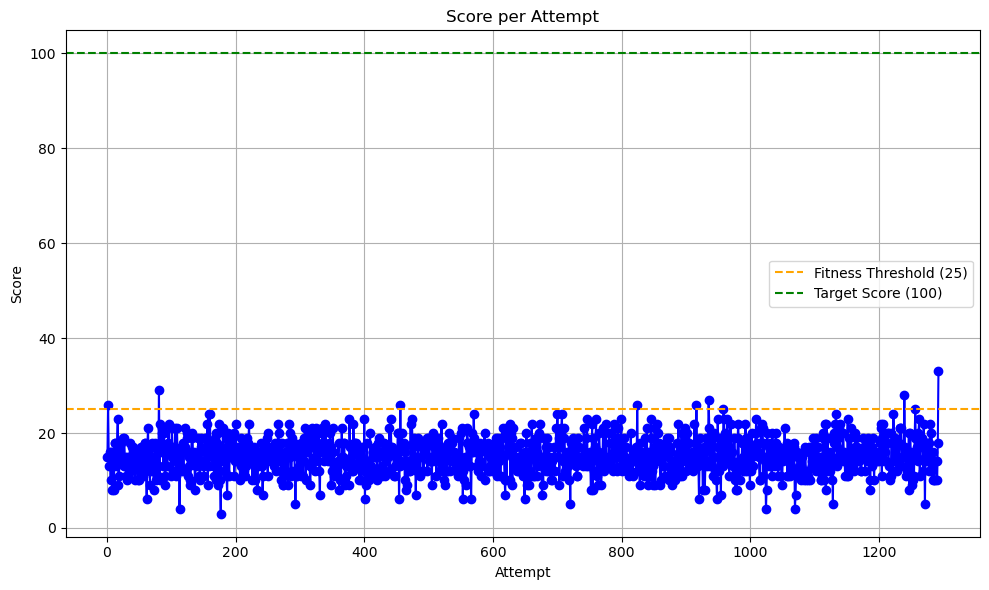

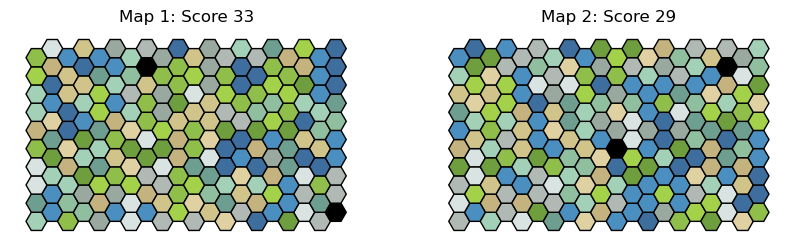

Gen 1: Best Score = 33
Gen 2: Best Score = 33
Gen 3: Best Score = 33
Gen 4: Best Score = 33
Gen 5: Best Score = 33
Gen 6: Best Score = 34
Gen 7: Best Score = 34
Gen 8: Best Score = 34
Gen 9: Best Score = 34
Gen 10: Best Score = 34
Gen 11: Best Score = 34
Gen 12: Best Score = 34
Gen 13: Best Score = 34
Gen 14: Best Score = 34
Gen 15: Best Score = 34
Gen 16: Best Score = 34
Gen 17: Best Score = 34
Gen 18: Best Score = 35
Gen 19: Best Score = 35
Gen 20: Best Score = 35
Gen 21: Best Score = 35
Gen 22: Best Score = 35
Gen 23: Best Score = 35
Gen 24: Best Score = 35
Gen 25: Best Score = 35
Gen 26: Best Score = 35
Gen 27: Best Score = 35
Gen 28: Best Score = 35
Gen 29: Best Score = 35
Gen 30: Best Score = 35
Gen 31: Best Score = 35
Gen 32: Best Score = 35
Gen 33: Best Score = 35
Gen 34: Best Score = 35
Gen 35: Best Score = 35
Gen 36: Best Score = 35
Gen 37: Best Score = 35
Gen 38: Best Score = 35
Gen 39: Best Score = 35
Gen 40: Best Score = 35
Gen 41: Best Score = 35
Gen 42: Best Score = 35
G

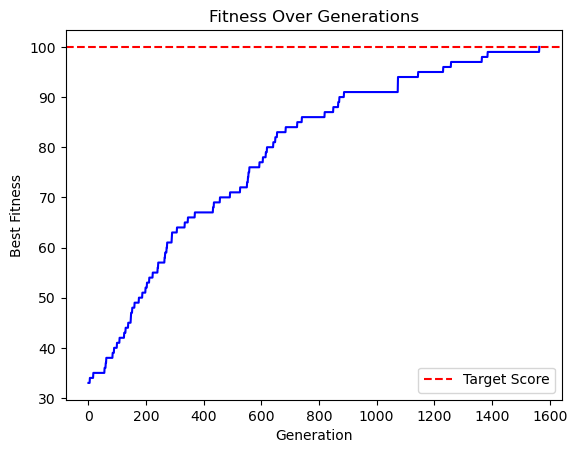

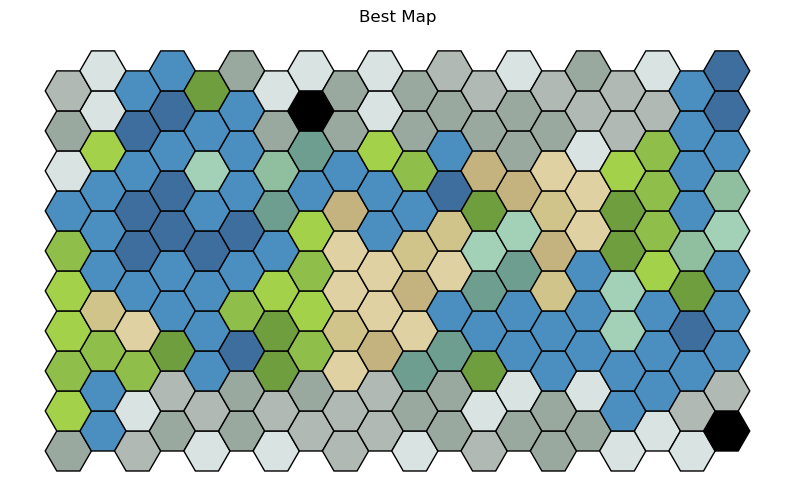

In [305]:
best_map = run_genetic_ai_until_goal(POPULATION_SIZE, FITNESS_THRESHOLD, MUTATION_RATE, SCORE_TO_ACHIEVE)

tile_data = best_map['map']
start_positions = best_map['spawns']

# Display the generated map visually
display_best_map(tile_data, start_positions)

# Compute map dimensions from tile_data
width = max(c for (_, c) in tile_data.keys()) + 1
height = max(r for (r, _) in tile_data.keys()) + 1

